In [156]:
import os
import cv2
import math
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [157]:
def ReadImage(InputImagePath):
    Images = []                     # Input Images will be stored in this list.
    ImageNames = []                 # Names of input images will be stored in this list.
    
    # Checking if path is of file or folder.
    if os.path.isfile(InputImagePath):   # If path is of file.
        InputImage = cv2.imread(InputImagePath)                 # Reading the image.
        
        # Checking if image is read.
        if InputImage is None:
            print("Image not read. Provide a correct path")
            exit()
        
        Images.append(InputImage)                               # Storing the image.
        ImageNames.append(os.path.basename(InputImagePath))     # Storing the image's name.

    # If path is of a folder contaning images.
    elif os.path.isdir(InputImagePath):
        # Getting all image's name present inside the folder.
        for ImageName in os.listdir(InputImagePath):
            # Reading images one by one.
            InputImage = cv2.imread(InputImagePath + "/" + ImageName)
            Images.append(InputImage)                           # Storing images.
            ImageNames.append(ImageName)                        # Storing image's names.
        
    # If it is neither file nor folder(Invalid Path).
    else:
        print("\nEnter valid Image Path.\n")
        exit()

    return Images, ImageNames

In [158]:
# Threshold by which lines will be rejected wrt the horizontal
REJECT_DEGREE_TH = 4.0

def FilterLines(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1, x2, y2]] = Line

        # Calculating equation of the line: y = mx + c
        if x1 != x2:
            m = (y2 - y1) / (x2 - x1)
        else:
            m = 100000000
        c = y2 - m*x2
        # theta will contain values between -90 -> +90. 
        theta = math.degrees(math.atan(m))

        # Rejecting lines of slope near to 0 degree or 90 degree and storing others
        if REJECT_DEGREE_TH <= abs(theta) <= (90 - REJECT_DEGREE_TH):
            l = math.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )    # length of the line
            FinalLines.append([x1, y1, x2, y2, m, c, l])

    
    # Removing extra lines 
    # (we might get many lines, so we are going to take only longest 15 lines 
    # for further computation because more than this number of lines will only 
    # contribute towards slowing down of our algo.)
    if len(FinalLines) > 15:
        FinalLines = sorted(FinalLines, key=lambda x: x[-1], reverse=True)
        FinalLines = FinalLines[:15]
    
    return FinalLines

In [159]:
def GetLines(Image):
    # Converting to grayscale
    GrayImage = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    M_GrayImage = cv2.cvtColor(GrayImage, cv2.COLOR_RGB2BGR)
    plt.imshow(M_GrayImage)
    plt.show()
    
    # Blurring image to reduce noise.
    BlurGrayImage = cv2.GaussianBlur(GrayImage, (5, 5), 1)
    M_BlurGrayImage = cv2.cvtColor(BlurGrayImage, cv2.COLOR_RGB2BGR)
    plt.imshow(M_BlurGrayImage)
    plt.show()
    # Generating Edge image
    EdgeImage = cv2.Canny(BlurGrayImage, 40, 255)
    M_EdgeImage = cv2.cvtColor(EdgeImage, cv2.COLOR_RGB2BGR)
    
#     plt.imshow(M_EdgeImage)
#     plt.show()

    # Finding Lines in the image
    Lines = cv2.HoughLinesP(EdgeImage, 1, np.pi / 180, 50, 10, 15)
    M_Line_EdgeImage = cv2.cvtColor(EdgeImage, cv2.COLOR_RGB2BGR)
    plt.imshow(M_Line_EdgeImage)
    plt.show()
    # Check if lines found and exit if not.
    if Lines is None:
        print("Not enough lines found in the image for Vanishing Point detection.")
        exit(0)
    
    # Filtering Lines wrt angle
    FilteredLines = FilterLines(Lines)

    return FilteredLines

In [160]:
def GetVanishingPoint(Lines):
    # We will apply RANSAC inspired algorithm for this. We will take combination 
    # of 2 lines one by one, find their intersection point, and calculate the 
    # total error(loss) of that point. Error of the point means root of sum of 
    # squares of distance of that point from each line.
    VanishingPoint = None
    MinError = 100000000000

    for i in range(len(Lines)):
        for j in range(i+1, len(Lines)):
            m1, c1 = Lines[i][4], Lines[i][5]
            m2, c2 = Lines[j][4], Lines[j][5]

            if m1 != m2:
                x0 = (c1 - c2) / (m2 - m1)
                y0 = m1 * x0 + c1

                err = 0
                for k in range(len(Lines)):
                    m, c = Lines[k][4], Lines[k][5]
                    m_ = (-1 / m)
                    c_ = y0 - m_ * x0

                    x_ = (c - c_) / (m_ - m)
                    y_ = m_ * x_ + c_

                    l = math.sqrt((y_ - y0)**2 + (x_ - x0)**2)

                    err += l**2

                err = math.sqrt(err)

                if MinError > err:
                    MinError = err
                    VanishingPoint = [x0, y0]
                
    return VanishingPoint

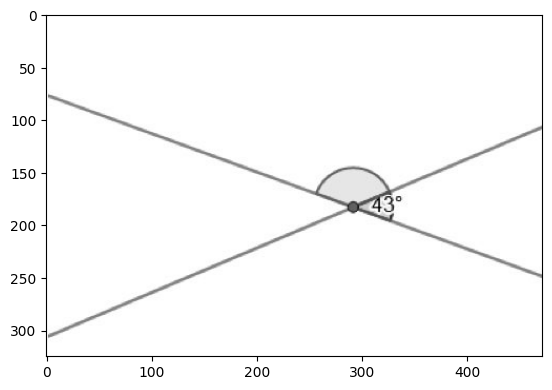

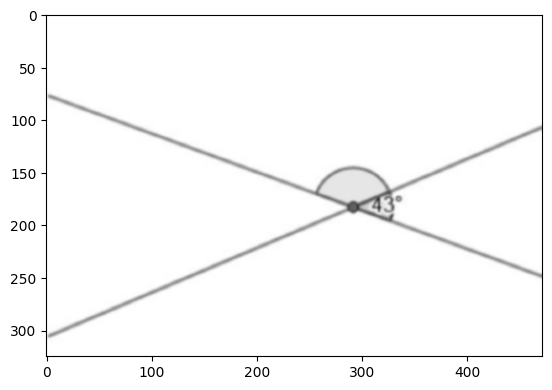

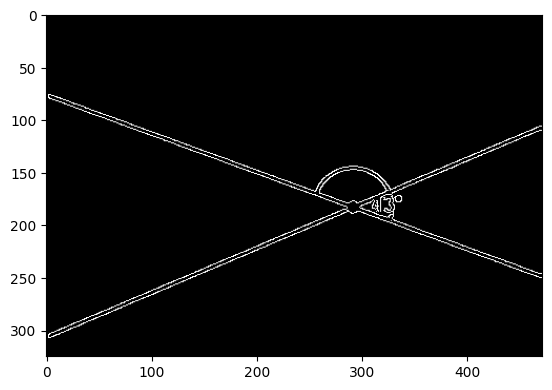

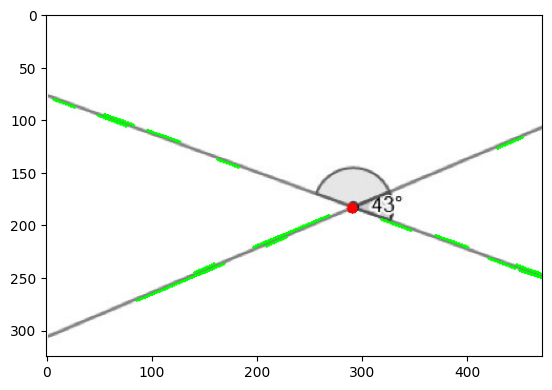

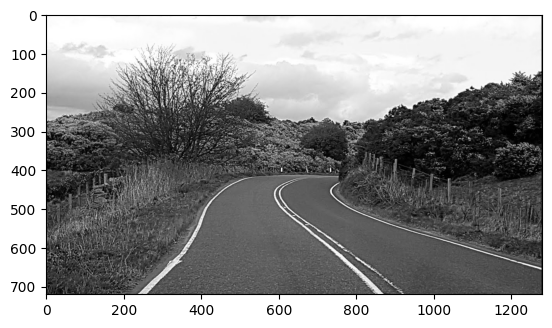

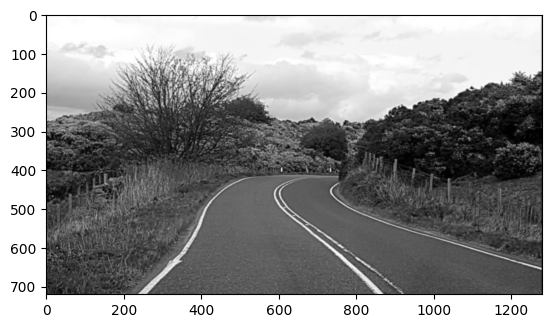

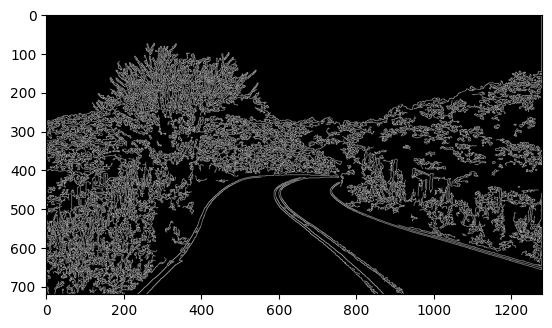

C:\Users\MSI 1\AppData\Local\Temp\ipykernel_13524\3257300297.py:15: RuntimeWarning: overflow encountered in scalar multiply
  c = y2 - m*x2


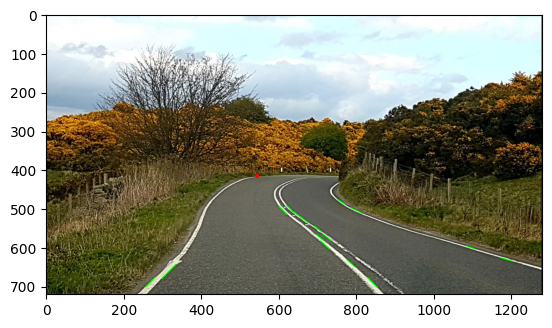

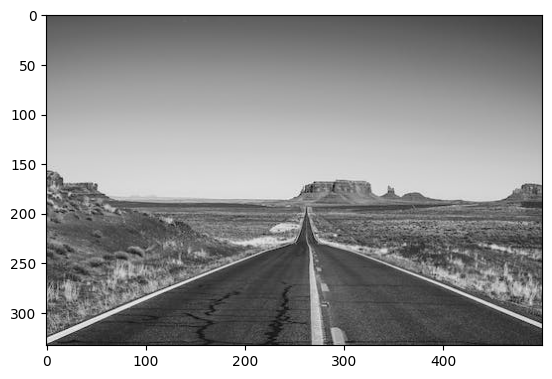

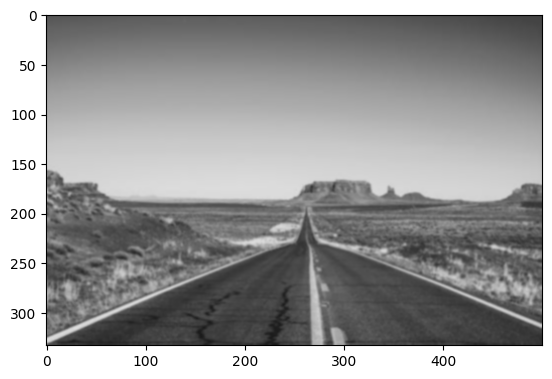

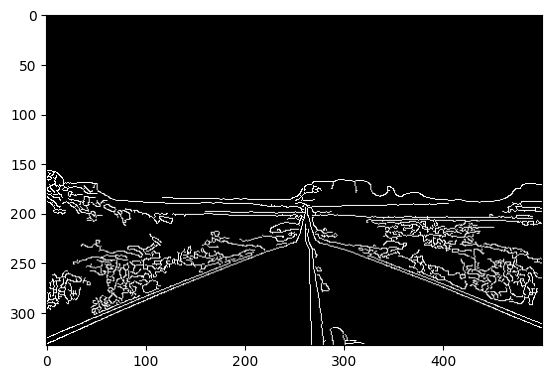

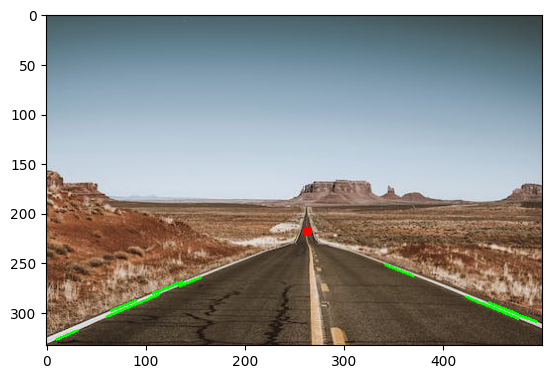

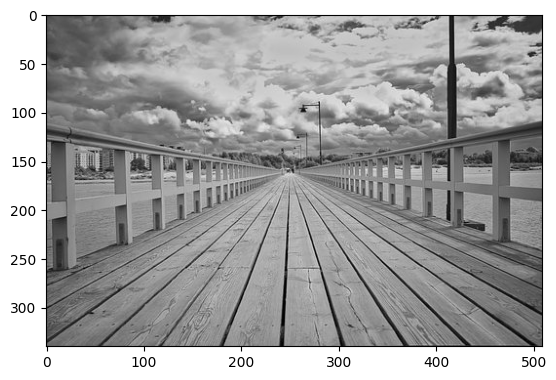

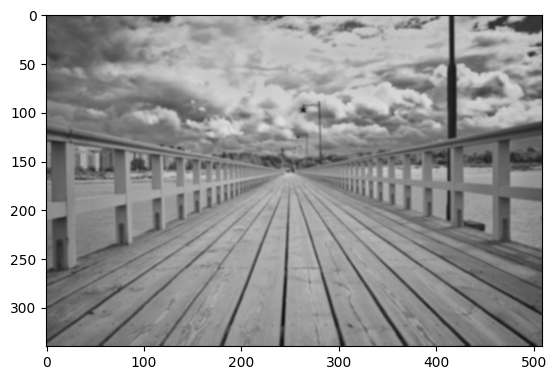

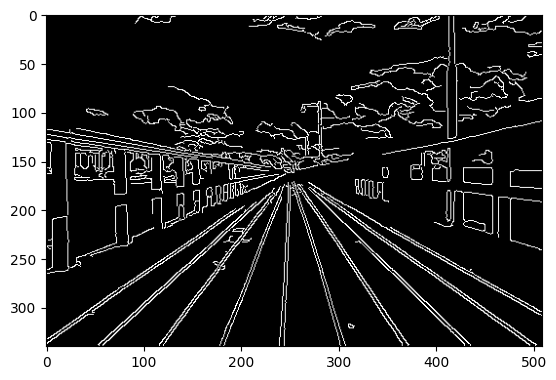

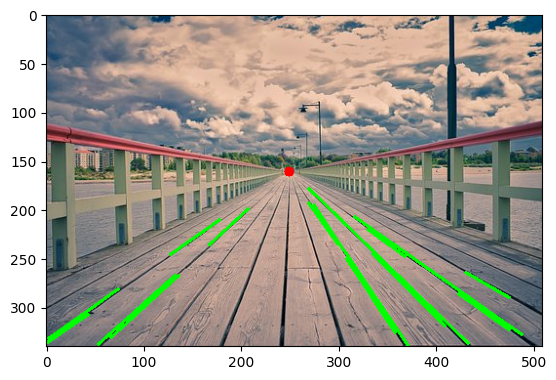

In [161]:
if __name__ == "__main__":
    Images, ImageNames = ReadImage("Example_images")            # Reading all input images
    
    for i in range(len(Images)):
        Image = Images[i]

        # Getting the lines form the image
        Lines = GetLines(Image)

        # Get vanishing point
        VanishingPoint = GetVanishingPoint(Lines)

        # Checking if vanishing point found
        if VanishingPoint is None:
            Image = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)
        
            # Showing the final image
            plt.imshow(Image)
            plt.show()
            print("Vanishing Point not found. Possible reason is that not enough lines are found in the image for determination of vanishing point.")
#             cv2.imshow('None Image',Image )
#             cv2.waitKey(0)

            continue

        # Drawing lines and vanishing point
        for Line in Lines:
            cv2.line(Image, (Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
        cv2.circle(Image, (int(VanishingPoint[0]), int(VanishingPoint[1])), 5, (0, 0, 255), -1)
        Image = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)
        
        # Showing the final image
        plt.imshow(Image)
        plt.show()
#         cv2.imshow("OutputImage", Image)
#         cv2.waitKey(0)